# Cointegration Discovery: Engle-Granger + ADF

This notebook finds cointegrated stock groups using:
- Engle-Granger cointegration test (`statsmodels.tsa.stattools.coint`)
- Augmented Dickey-Fuller (ADF) test on the OLS residual spread (`statsmodels.tsa.stattools.adfuller`)

Output:
- a list of cointegrated pairs (p-values)
- asset groups via connected components over cointegration edges
- common daily price charts for each group with a legend labeling every asset

Time split:
- tests are run on the train window (first 7 years)
- charts use full available history


In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint, adfuller


In [2]:
# Resolve project root robustly
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [3]:
from src.backtester.data import load_cleaned_assets, align_close_prices

assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index().ffill().bfill()

TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(close_daily.index.min())
end = pd.Timestamp(close_daily.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

train_close = close_daily.loc[start:train_end].copy()

print('date range:', start.date(), '->', end.date())
print('train window:', train_close.index.min().date(), '->', train_close.index.max().date())
print('n_assets:', train_close.shape[1])


date range: 2016-01-25 -> 2026-01-16
train window: 2016-01-25 -> 2023-01-25
n_assets: 100


In [4]:
# Pair screening (runtime control)
# Set SCREEN_TOPK_PER_ASSET=None and/or MAX_PAIRS=None to test more pairs (slower).

CORR_MIN_ABS = 0.3
SCREEN_TOPK_PER_ASSET = 20   # keep top-k correlated partners per asset
MAX_PAIRS = 3000             # hard cap on total tested pairs

PVAL_COINTEGRATION = 0.05
PVAL_ADF = 0.05

print('CORR_MIN_ABS:', CORR_MIN_ABS)
print('SCREEN_TOPK_PER_ASSET:', SCREEN_TOPK_PER_ASSET)
print('MAX_PAIRS:', MAX_PAIRS)
print('PVAL_COINTEGRATION:', PVAL_COINTEGRATION, 'PVAL_ADF:', PVAL_ADF)


CORR_MIN_ABS: 0.3
SCREEN_TOPK_PER_ASSET: 20
MAX_PAIRS: 3000
PVAL_COINTEGRATION: 0.05 PVAL_ADF: 0.05


In [5]:
# Build candidate pairs from correlation screen (train window)

ret = train_close.pct_change().dropna(how='all')
ret = ret.dropna(axis=1, how='any')
assets = ret.columns.tolist()

corr = ret.corr().fillna(0.0)

pairs = set()
for i, a in enumerate(assets):
    c = corr.loc[a].abs().to_numpy().copy()
    c[i] = -1.0

    idx_sorted = np.argsort(-c)
    if SCREEN_TOPK_PER_ASSET is not None:
        idx_sorted = idx_sorted[:SCREEN_TOPK_PER_ASSET]

    for j in idx_sorted:
        if c[j] < CORR_MIN_ABS:
            continue
        b = assets[int(j)]
        if a == b:
            continue
        pair = tuple(sorted((a, b)))
        pairs.add(pair)

pairs = sorted(pairs)
if MAX_PAIRS is not None:
    pairs = pairs[:MAX_PAIRS]

print('assets:', len(assets))
print('candidate pairs:', len(pairs))


assets: 100
candidate pairs: 1495


In [6]:
# Engle-Granger + explicit ADF on residual spread

logp = np.log(train_close.loc[:, assets].astype(float))

rows = []
for k, (a, b) in enumerate(pairs, start=1):
    y = logp[a]
    x = logp[b]
    idx = y.index.intersection(x.index)
    if len(idx) < 252 * 2:
        continue

    yv = y.loc[idx].to_numpy(dtype=float)
    xv = x.loc[idx].to_numpy(dtype=float)

    # Engle-Granger cointegration test (includes internal ADF on residual)
    try:
        _score, p_coint, _crit = coint(yv, xv)
    except Exception:
        continue

    # OLS to form residual spread, then explicit ADF
    X = np.column_stack([np.ones_like(xv), xv])
    beta, *_ = np.linalg.lstsq(X, yv, rcond=None)
    a0 = float(beta[0])
    b1 = float(beta[1])
    resid = yv - (a0 + b1 * xv)

    try:
        adf_stat, p_adf, *_ = adfuller(resid, autolag='AIC')
    except Exception:
        continue

    rows.append(
        {
            'A': a,
            'B': b,
            'n': int(len(idx)),
            'p_coint': float(p_coint),
            'p_adf_resid': float(p_adf),
            'beta': float(b1),
        }
    )

    if k % 200 == 0:
        print('tested', k, '/', len(pairs), 'kept', len(rows))

res_df = pd.DataFrame(rows)
res_df = res_df.sort_values(['p_coint', 'p_adf_resid'], ascending=True).reset_index(drop=True)

print('tested pairs:', len(pairs))
print('results rows:', res_df.shape)
display(res_df.head(20))


tested 200 / 1495 kept 200
tested 400 / 1495 kept 400
tested 600 / 1495 kept 600
tested 800 / 1495 kept 800
tested 1000 / 1495 kept 1000
tested 1200 / 1495 kept 1200
tested 1400 / 1495 kept 1400
tested pairs: 1495
results rows: (1495, 6)


,A,B,n,p_coint,p_adf_resid,beta
0,Asset_054,Asset_087,1764,0.000153,0.000021,0.945753
1,Asset_031,Asset_035,1764,0.000179,0.000024,1.245930
2,Asset_010,Asset_016,1764,0.000216,0.000030,0.788498
3,Asset_020,Asset_035,1764,0.000267,0.000038,0.923055
4,Asset_002,Asset_046,1764,0.000291,0.000041,1.449532
5,Asset_081,Asset_096,1764,0.000325,0.000046,2.315606
6,Asset_015,Asset_038,1764,0.000380,0.000055,0.708660
7,Asset_020,Asset_037,1764,0.000591,0.000089,0.921370
8,Asset_015,Asset_046,1764,0.000729,0.000112,0.719873
9,Asset_053,Asset_086,1764,0.000975,0.000153,0.341502


In [7]:
# Select cointegrated edges and build groups via connected components

edges = res_df[(res_df['p_coint'] <= PVAL_COINTEGRATION) & (res_df['p_adf_resid'] <= PVAL_ADF)].copy()
print('edges kept:', edges.shape[0])
display(edges.head(20))

# Union-Find
parent = {a: a for a in assets}


def find(x: str) -> str:
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x


def union(a: str, b: str) -> None:
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for _, r in edges.iterrows():
    union(str(r['A']), str(r['B']))

comps: dict[str, list[str]] = {}
for a in assets:
    comps.setdefault(find(a), []).append(a)

# Keep groups of size >=2
comp_list = [v for v in comps.values() if len(v) >= 2]
comp_list = sorted(comp_list, key=len, reverse=True)

cointegrated_groups: dict[int, list[str]] = {i: v for i, v in enumerate(comp_list)}
print('n_groups:', len(cointegrated_groups))
print('largest group sizes:', [len(v) for v in list(cointegrated_groups.values())[:10]])

# Group summary
summary_rows = []
for gid, syms in cointegrated_groups.items():
    sub = edges[(edges['A'].isin(syms)) & (edges['B'].isin(syms))]
    if sub.empty:
        continue
    summary_rows.append(
        {
            'group': int(gid),
            'n_assets': int(len(syms)),
            'n_edges': int(sub.shape[0]),
            'p_coint_median': float(sub['p_coint'].median()),
            'p_adf_median': float(sub['p_adf_resid'].median()),
        }
    )
summary = pd.DataFrame(summary_rows).sort_values(['p_coint_median', 'p_adf_median'], ascending=True)
display(summary)


edges kept: 168


,A,B,n,p_coint,p_adf_resid,beta
0,Asset_054,Asset_087,1764,0.000153,0.000021,0.945753
1,Asset_031,Asset_035,1764,0.000179,0.000024,1.245930
2,Asset_010,Asset_016,1764,0.000216,0.000030,0.788498
3,Asset_020,Asset_035,1764,0.000267,0.000038,0.923055
4,Asset_002,Asset_046,1764,0.000291,0.000041,1.449532
5,Asset_081,Asset_096,1764,0.000325,0.000046,2.315606
6,Asset_015,Asset_038,1764,0.000380,0.000055,0.708660
7,Asset_020,Asset_037,1764,0.000591,0.000089,0.921370
8,Asset_015,Asset_046,1764,0.000729,0.000112,0.719873
9,Asset_053,Asset_086,1764,0.000975,0.000153,0.341502


n_groups: 2
largest group sizes: [73, 4]


,group,n_assets,n_edges,p_coint_median,p_adf_median
1,1,4,4,0.005503,0.001050
0,0,73,164,0.020232,0.004624


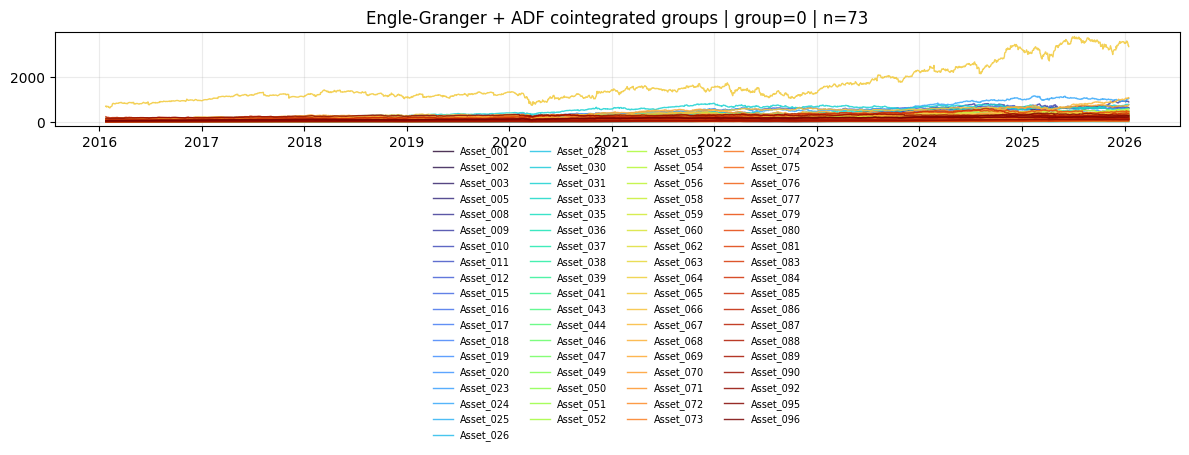

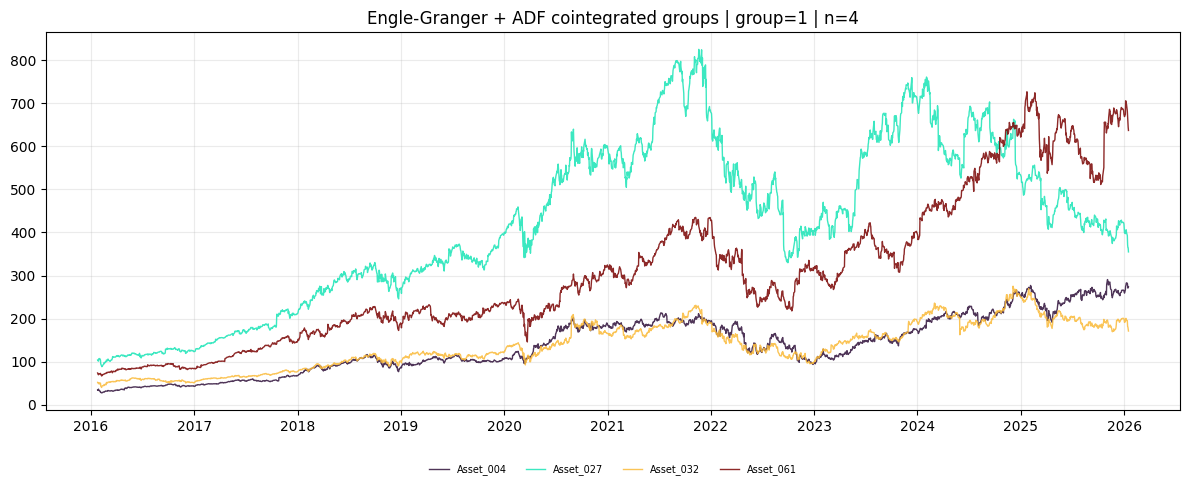

In [8]:
# Plot daily prices for each group (full history) with asset legend

def plot_group_prices(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, title: str) -> None:
    for gid in sorted(groups.keys()):
        syms = [s for s in groups[gid] if s in close_daily.columns]
        if len(syms) == 0:
            continue

        colors = plt.cm.turbo(np.linspace(0.0, 1.0, len(syms)))
        plt.figure(figsize=(12, 5))
        for i, s in enumerate(syms):
            plt.plot(close_daily.index, close_daily[s].astype(float), linewidth=1.0, alpha=0.85, color=colors[i], label=str(s))
        plt.title(f'{title} | group={gid} | n={len(syms)}')
        plt.grid(True, alpha=0.25)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=7, frameon=False)
        plt.tight_layout()
        plt.show()

plot_group_prices(cointegrated_groups, close_daily, title='Engle-Granger + ADF cointegrated groups')
